# Učitavanje potrebnih biblioteka i podataka

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('info.csv')

# Statistički pregled stanova u Hrvatskoj

## 1. Izračunavanje medijana cijene po kvadratnom metru u svakoj županiji

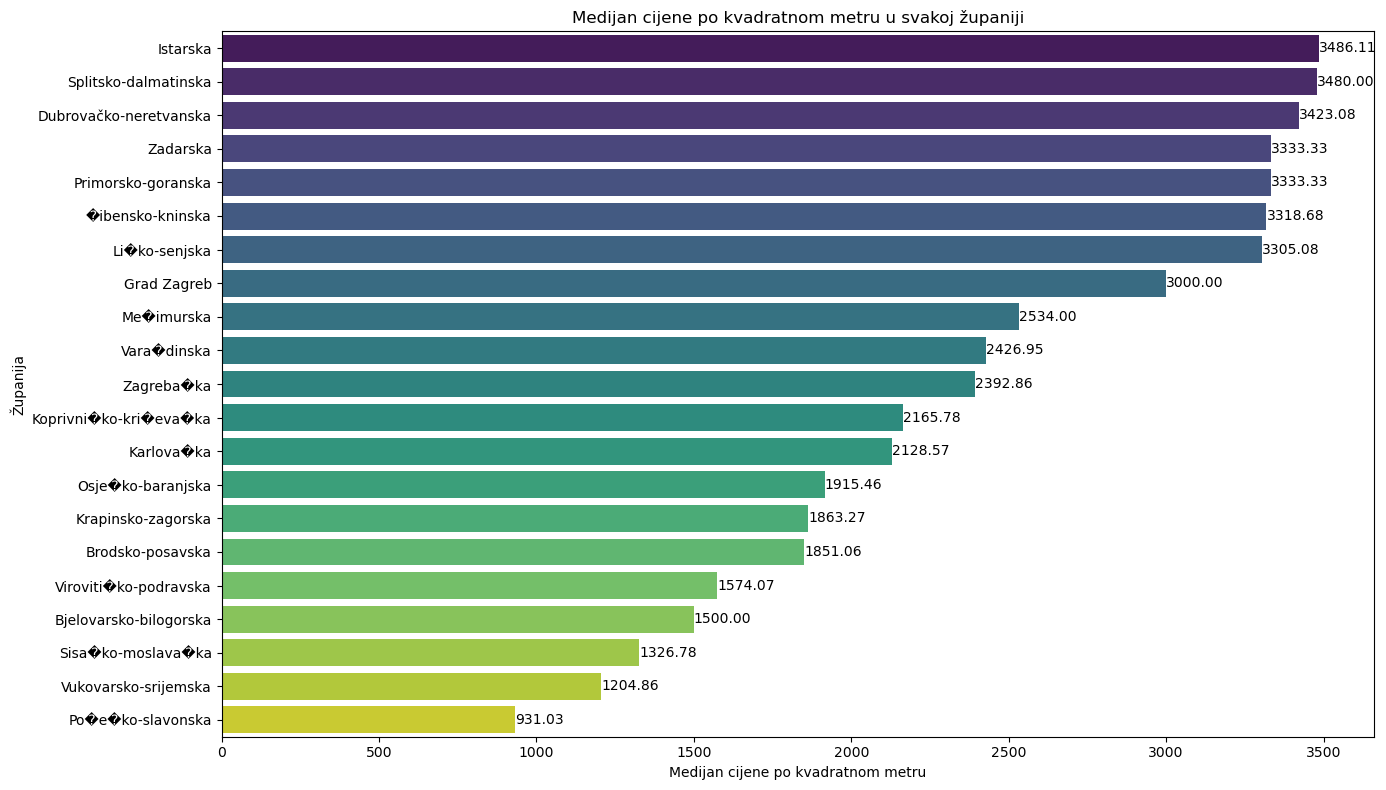

In [3]:
df['Price per sqm'] = df['Price'] / df['Living area']
county_counts = df['County'].value_counts()

valid_counties = county_counts[county_counts >= 3].index
df_filtered = df[df['County'].isin(valid_counties)]

median_price_per_sqm_county = df_filtered.groupby('County')['Price per sqm'].median().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=median_price_per_sqm_county.values, y=median_price_per_sqm_county.index, palette='viridis')
for index, value in enumerate(median_price_per_sqm_county.values):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=10)
plt.xlabel('Medijan cijene po kvadratnom metru')
plt.ylabel('Županija')
plt.title('Medijan cijene po kvadratnom metru u svakoj županiji')
plt.tight_layout()
plt.show()

## 2. Izračunavanje medijana cijene po kvadratnom metru u 10 najskupljih gradova

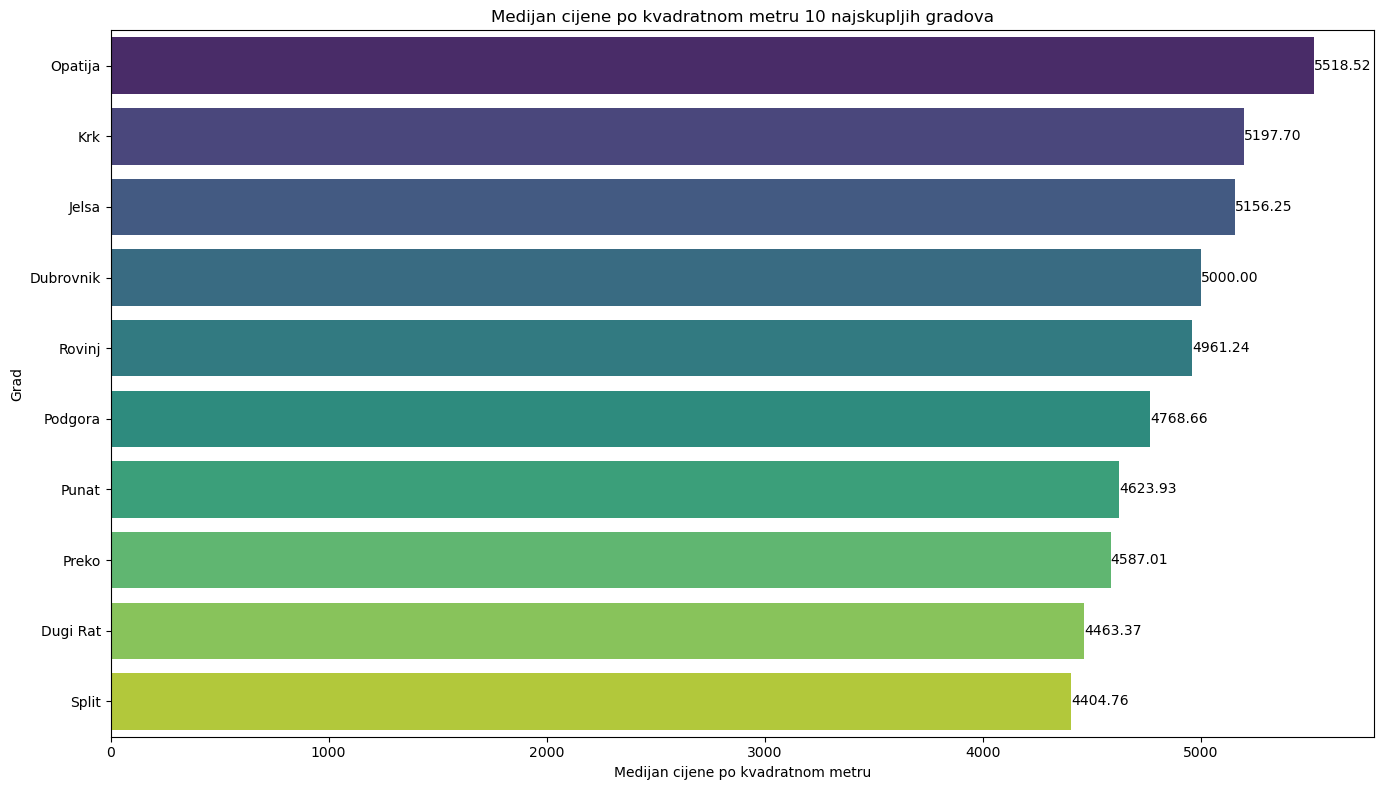

In [4]:
df['Price per sqm'] = df['Price'] / df['Living area']
city_counts = df['City'].value_counts()

valid_cities = city_counts[city_counts >= 3].index
df_filtered = df[df['City'].isin(valid_cities)]

median_price_per_sqm_city = df_filtered.groupby('City')['Price per sqm'].median().sort_values(ascending=False).head(10)

plt.figure(figsize=(14, 8))
sns.barplot(x=median_price_per_sqm_city.values, y=median_price_per_sqm_city.index, palette='viridis')
for index, value in enumerate(median_price_per_sqm_city.values):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=10)
plt.xlabel('Medijan cijene po kvadratnom metru')
plt.ylabel('Grad')
plt.title('Medijan cijene po kvadratnom metru 10 najskupljih gradova')
plt.tight_layout()
plt.show()

## 3. Izračunavanje medijana cijene po kvadratnom metru u 10 najpopularnijih gradova

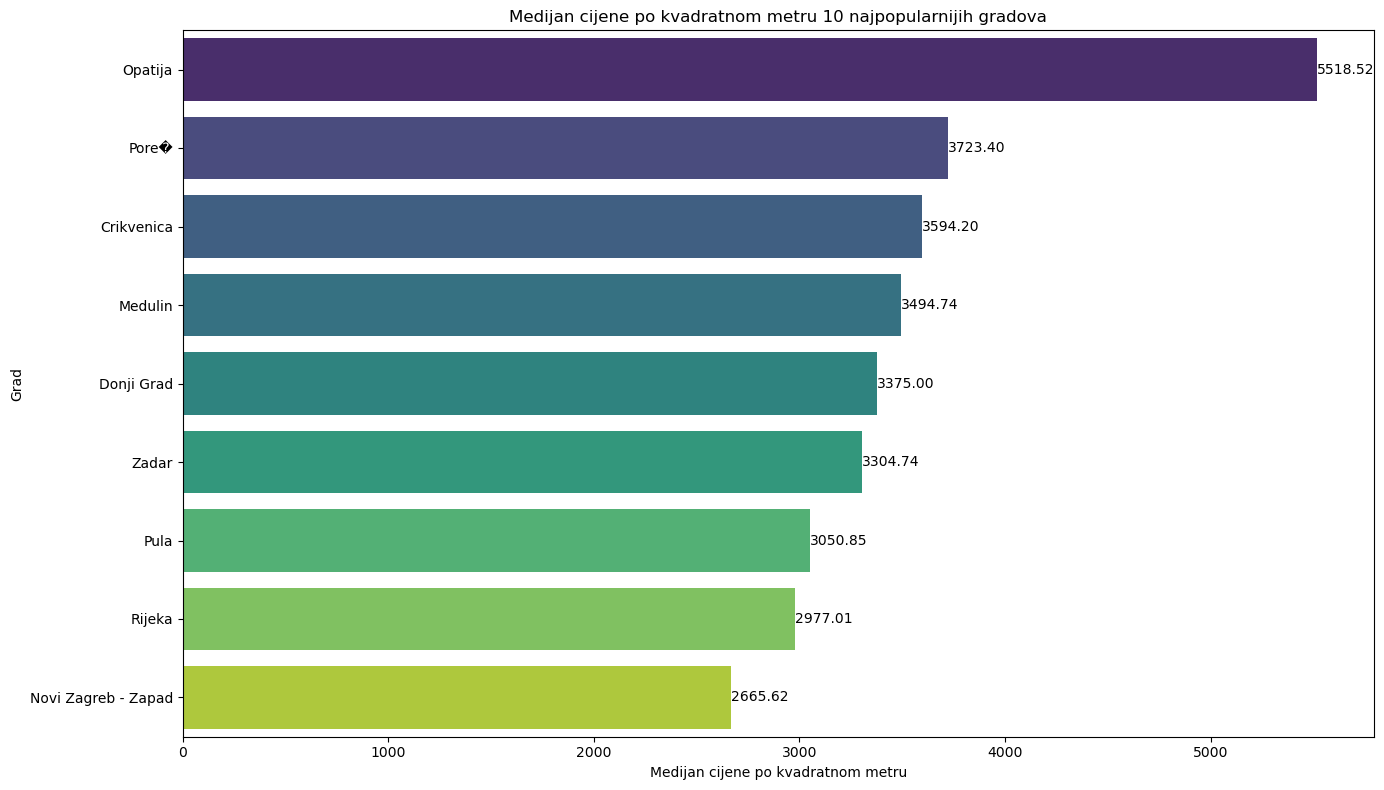

In [5]:
df['Price per sqm'] = df['Price'] / df['Living area']
city_counts = df['City'].value_counts().sort_values(ascending=False).head(9)

df_filtered = df[df['City'].isin(city_counts.index)]

median_price_per_sqm_city = df_filtered.groupby('City')['Price per sqm'].median().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=median_price_per_sqm_city.values, y=median_price_per_sqm_city.index, palette='viridis')
for index, value in enumerate(median_price_per_sqm_city.values):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=10)
plt.xlabel('Medijan cijene po kvadratnom metru')
plt.ylabel('Grad')
plt.title('Medijan cijene po kvadratnom metru 10 najpopularnijih gradova')
plt.tight_layout()
plt.show()

## 4. Broj objavljenih stanova u travnju

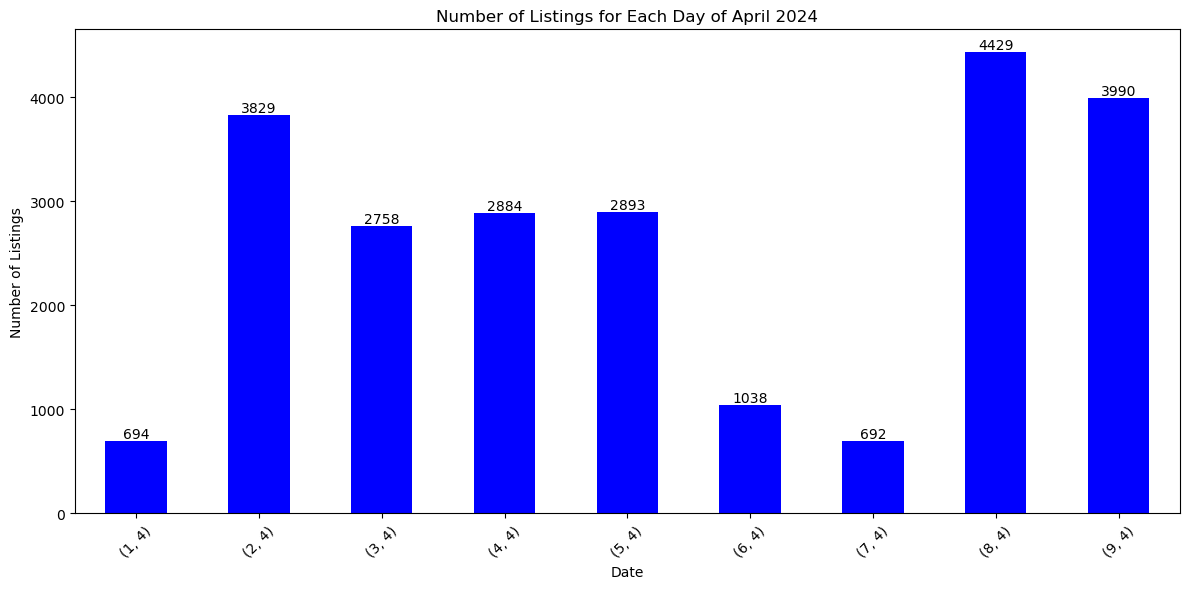

In [6]:
df['Date'] = pd.to_datetime(df['Date'].str.rstrip('.'), format='%d.%m.%Y')

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

df_march = df[(df['Year'] == 2024) & (df['Month'] == 4)]

listings_per_day = df_march.groupby(['Day', 'Month']).size()

plt.figure(figsize=(12, 6))
ax = listings_per_day.plot(kind='bar', color='b')
plt.xlabel('Date')
plt.ylabel('Number of Listings')
plt.title('Number of Listings for Each Day of April 2024')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

## 5. Cijena kvadratnog metra tijekom vremena
Ispitujemo je li postoje neki trendovi.

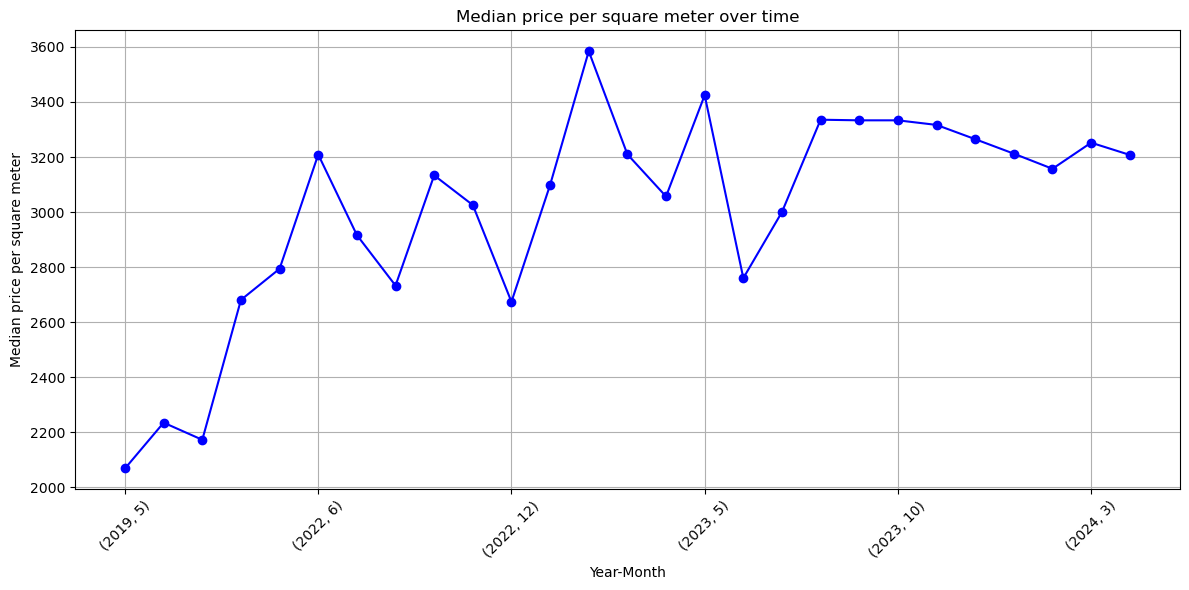

In [7]:
df['Price per sqm'] = df['Price'] / df['Living area']

df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
year_month_counts = df.groupby(['Year', 'Month']).size()

valid_year_months = year_month_counts[year_month_counts >= 20].index
df_filtered = df[df[['Year', 'Month']].apply(tuple, axis=1).isin(valid_year_months)]
median_price_per_sqm_year_month = df_filtered.groupby(['Year', 'Month'])['Price per sqm'].median()

plt.figure(figsize=(12, 6))
median_price_per_sqm_year_month.plot(marker='o', color='b', linestyle='-')
plt.xlabel('Year-Month')
plt.ylabel('Median price per square meter')
plt.title('Median price per square meter over time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

## 6. Pristutnost stanova po sobama

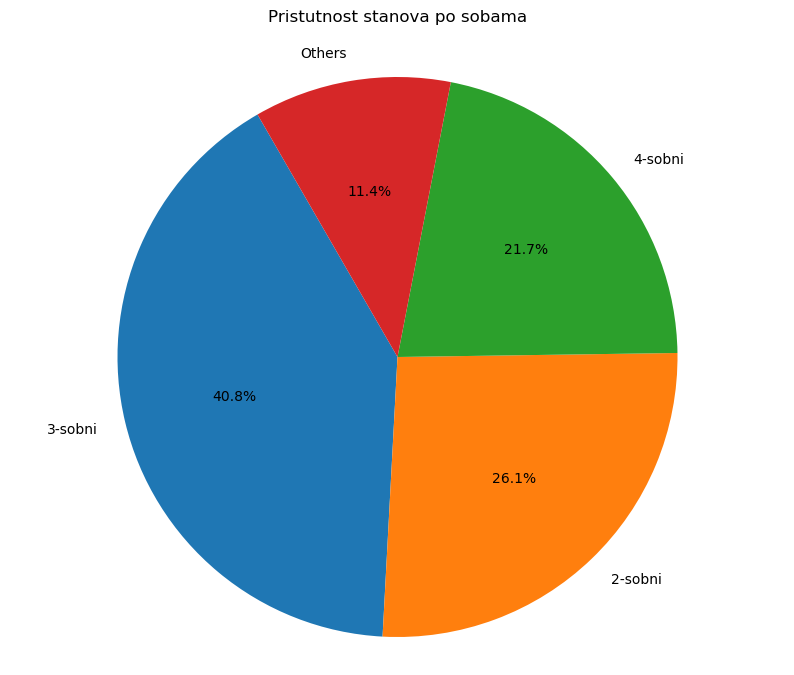

In [8]:
number_of_rooms_counts = df['Number of rooms'].value_counts()
total_occurrences = number_of_rooms_counts.sum()

top_three = number_of_rooms_counts.head(3)
others_percentage = number_of_rooms_counts[3:].sum()
percentage_occurrences = pd.concat([top_three, pd.Series([others_percentage], index=['Others'])])

plt.figure(figsize=(10, 8))
plt.pie(percentage_occurrences, labels=percentage_occurrences.index, autopct=lambda p: '{:.1f}%'.format(p) if p >= 2 else '', startangle=120)
plt.axis('equal')
plt.title('Pristutnost stanova po sobama', pad=20)
plt.show()

## 7. Energetska učinkovitost

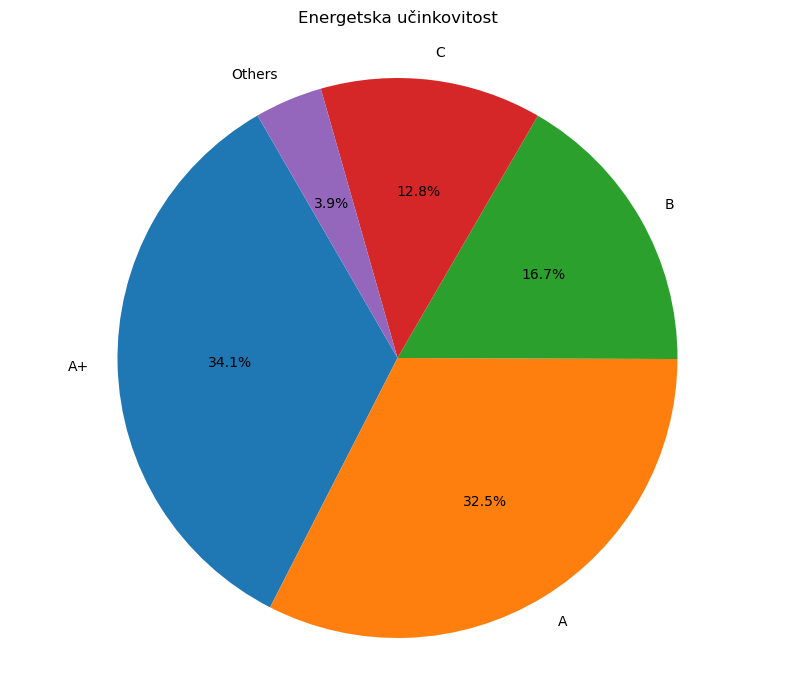

In [9]:
data = df[df['Energy class'] != 'Unknown']
energy_class_counts = data['Energy class'].value_counts()
total_occurrences = energy_class_counts.sum()

top_three = energy_class_counts.head(4)
others_percentage = energy_class_counts[4:].sum()
percentage_occurrences = pd.concat([top_three, pd.Series([others_percentage], index=['Others'])])

plt.figure(figsize=(10, 8))
plt.pie(percentage_occurrences, labels=percentage_occurrences.index, autopct=lambda p: '{:.1f}%'.format(p) if p >= 2 else '', startangle=120)
plt.axis('equal')
plt.title('Energetska učinkovitost', pad=20)
plt.show()

## 8. Izračunavanje medijana cijene po kvadratnom metru za svaki kat

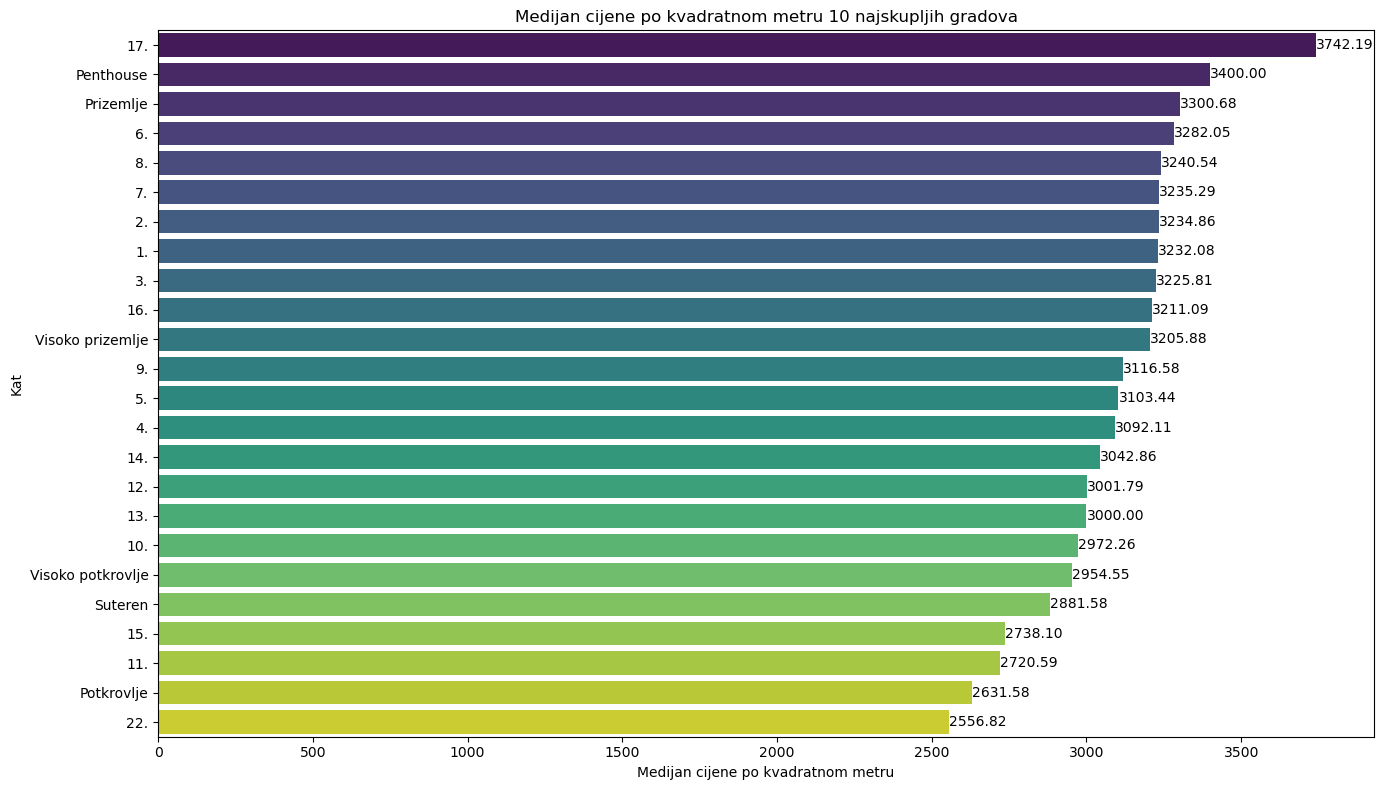

In [10]:
df = df[df['Floor'] != 'Unknown']
floor_counts = df['Floor'].value_counts()

valid_floors = floor_counts[floor_counts >= 10].index
df_filtered = df[df['Floor'].isin(valid_floors)]

median_price_per_sqm_city = df_filtered.groupby('Floor')['Price per sqm'].median().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=median_price_per_sqm_city.values, y=median_price_per_sqm_city.index, palette='viridis')
for index, value in enumerate(median_price_per_sqm_city.values):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=10)
plt.xlabel('Medijan cijene po kvadratnom metru')
plt.ylabel('Kat')
plt.title('Medijan cijene po kvadratnom metru 10 najskupljih gradova')
plt.tight_layout()
plt.show()

# Statistički pregled stanova u Splitskoj-dalmatinskoj županiji

## 1.Izračunavanje medijana cijene po kvadratnom metru kvartova u gradu Splitu

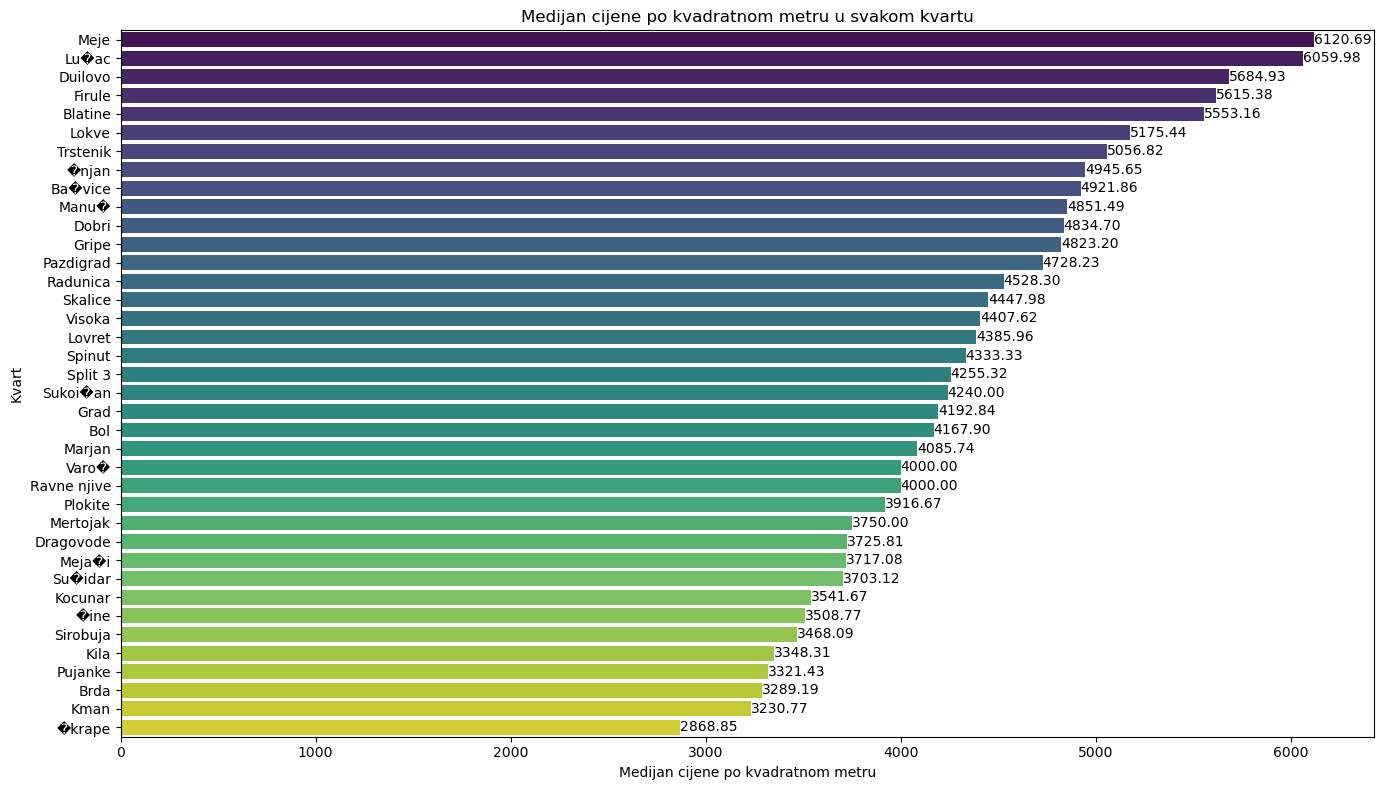

In [11]:
split_data = df[df['City'] == 'Split']
neighborhood_counts = split_data['Neighborhood'].value_counts()

valid_neighborhoods = neighborhood_counts[neighborhood_counts >= 5].index
df_filtered = df[df['Neighborhood'].isin(valid_neighborhoods)]

median_price_per_sqm_neighborhood = df_filtered.groupby('Neighborhood')['Price per sqm'].median().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=median_price_per_sqm_neighborhood.values, y=median_price_per_sqm_neighborhood.index, palette='viridis')
for index, value in enumerate(median_price_per_sqm_neighborhood.values):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=10)
plt.xlabel('Medijan cijene po kvadratnom metru')
plt.ylabel('Kvart')
plt.title('Medijan cijene po kvadratnom metru u svakom kvartu')
plt.tight_layout()
plt.show()